The goal is to find a way to predict counts, assuming we have a 4x segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
from collections import defaultdict
%matplotlib inline

In [2]:
np.random.seed(21)

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Flatten, Dense, Activation, Cropping2D, Reshape, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.engine.topology import Layer

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [5]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

In [6]:
class OHELayer(Layer):

    def __init__(self, n_classes, **kwargs):
        self.n_classes = n_classes
        super(OHELayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(OHELayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        x = K.cast(x, tf.int32)
        y = K.one_hot(x, num_classes=self.n_classes)
        return y

    def compute_output_shape(self, input_shape):
        return input_shape + (self.n_classes, )
    
    def get_config(self):
        config = {'n_classes': self.n_classes}
        base_config = super(OHELayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
class SumLayer(Layer):

    def __init__(self, **kwargs):
        super(SumLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SumLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return K.sum(K.sum(x, axis=1), axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], ) + (input_shape[-1], )
    
    def get_config(self):
        base_config = super(SumLayer, self).get_config()
        return base_config

In [ ]:
def get_cntnet(im_height, im_width, n_channels=1):
    inputs = Input((im_height, im_width, n_channels))
    x = OHELayer(6)(inputs)
    print(x.shape)
    x = SumLayer()(x)
    print(x.shape)
    x = Flatten()(x)
    x = Dense(32, kernel_initializer='uniform')(x)
    x = Dense(5, kernel_initializer='constant')(x)
    model = Model(inputs=[inputs], outputs=[x], name="cnt_net")
    return model

In [35]:
def get_cntnet(im_height, im_width, n_channels=1):
    inputs = Input((im_height, im_width, n_channels))
    x = OHELayer(6)(inputs)
    x = Reshape((256, 256, 6))(x)
    print(x.shape)
    x = AveragePooling2D((8, 8))(x)
    print(x.shape)
    x = Flatten()(x)
    x = Dense(5, kernel_initializer='constant')(x)
    model = Model(inputs=[inputs], outputs=[x], name="cnt_net")
    return model

In [36]:
unet = get_cntnet( 256, 256)

(?, 256, 256, 6)
(?, 32, 32, 6)


In [37]:
t = np.ones((1, 256, 256, 1))
counts = unet.predict(t)
print("Counts output: ", counts.shape)

Counts output:  (1, 5)


In [38]:
unet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
ohe_layer_5 (OHELayer)       (None, 256, 256, 1, 6)    0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 256, 256, 6)       0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 32, 32, 6)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30725     
Total params: 30,725
Trainable params: 30,725
Non-trainable params: 0
_________________________________________________________________


In [39]:
class NonValidPatch(Exception):
    pass

In [40]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights,
                 n_samples_per_image=160,
                 target_size=(256, 256),
                 scale = 1,
                 crop = (0, 0),
                 batch_size=16, shuffle=True, seed=42,
                 debug_dir=None):
        self.n_samples_per_block = 8
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.crop = crop
        self.scale = scale
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
        super(PatchIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
        
    def compute_class_distribution(self, n_batches):
        seg_freqs = defaultdict(int)
        count_freqs = {0: defaultdict(int),
                             1: defaultdict(int),
                             2: defaultdict(int),
                             3: defaultdict(int),
                             4: defaultdict(int)}
        for b in range(n_batches):
            _, [by, bcounts] = self.next()
            by = np.argmax(by, axis=-1)
            ids, freqs = np.unique(by, return_counts=True)
            for i in range(ids.shape[0]):
                seg_freqs[ids[i]] += freqs[i]
            for b in range(bcounts.shape[0]):
                counts = bcounts[b]
                for i in range(counts.shape[0]):
                    count_freqs[i][counts[i]] += 1
        
        return seg_freqs, count_freqs

    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        return x

    def normalize_output(self, y):
        yc = y.copy()
        for i in range(y.shape[0]):
            yc[i] = self.quantify(y[i])
        return to_categorical(yc, 64)
    
    def quantify(self, y):
        if y == 0:
            return 0
        else:
            return min(y//2 + 1, 63)
        
    def dequantify(self, y_normed):
        if y_normed == 0:
            return 0
        else:
            cnt = (y_normed - 1) * 2
            if cnt == 0:
                cnt = 1
            return cnt
        
    def denormalize_output(self, y_normed): 
        yc = y_normed.copy()
        for i in range(y_normed.shape[0]):
            yc[i] = self.dequantifiy(y_normed[i])
        return yc
        
    def random_transform(self, x):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
        if flips[1]:
            x = np.flipud(x)
        if flips[2]:
            x = np.fliplr(x)
        return x
                     
    def get_dots_in_patch(self, sx, sy, dots):
        dots_in_patch = [[] for _ in dots]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if sx <= x < sx + self.target_size[1] and sy <= y < sy + self.target_size[0]:
                    dots_in_patch[i].append((x - sx, y - sy))
        return dots_in_patch
    
    def build_counts(self, dots):
        h = (self.target_size[0] - 2 * self.crop[0])//self.scale
        w = (self.target_size[1] - 2 * self.crop[1])//self.scale
        counts = np.zeros((5, ), dtype=np.int32)
        for c, ds in enumerate(dots):
            for (x, y) in ds:
                xr = int(round((x - self.crop[1])/self.scale))
                yr = int(round((y - self.crop[0])/self.scale))

                if 0 <= xr < w and 0 <= yr < h:
                    counts[c] += 1
        return counts
          
    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample(self, shape, dots, image_id):
        margin = self.crop[0] + 30
        max_iterations = self.n_samples_per_block * 5
        
        smap = np.load(os.path.join(self.root_dir, "TrainSegmentationIgnored4x", str(image_id) + ".npz"))["smap"]                                                                          
        n_samples = 0
        bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1]))
        bcounts = np.zeros((self.n_samples_per_block, 5))

        current_iteration = 0
        weights = self.get_weights(dots)
        
        # Samples n dots, with some probabilty to get the background only
        while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
            current_iteration += 1
            try:
                # Choose an output class randomly
                output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=weights)[0]
                
                # Background, select randomly a patch in the image (high chance to get only background)
                if output_class == self.n_sealion_types:
                    sx_min = 0
                    sx_max = shape[1] - self.target_size[1]
                    sy_min = 0
                    sy_max = shape[0] - self.target_size[0]
                # Choose a dot randomly in that class
                else:  
                    dot_index = np.random.randint(0, len(dots[output_class]))
                    rx, ry = dots[output_class][dot_index]
                    sx_min = min(max(0, rx - self.target_size[1] + margin), shape[1] - self.target_size[1])
                    sx_max = min(max(0, rx - margin), shape[1] - self.target_size[1])
                    sy_min = min(max(0, ry - self.target_size[0] + margin), shape[0] - self.target_size[1])
                    sy_max = min(max(0, ry - margin), shape[0] - self.target_size[0]) 
                
                    if sx_min >= sx_max:
                        sx_min = min(max(0, rx - self.target_size[1]), shape[1] - self.target_size[1])
                        sx_max = min(max(0, rx), shape[1] - self.target_size[1])
                        
                    if sy_min >= sy_max:
                        sy_min = min(max(0, ry - self.target_size[0]), shape[0] - self.target_size[1])
                        sy_max = min(max(0, ry), shape[0] - self.target_size[0]) 
                    
                if sx_min >= sx_max or sy_min >= sy_max:
                        continue
                        
                # Choose the top-left corner so that the dot selected is in the patch.
                sx = np.random.randint(sx_min, sx_max)
                sy = np.random.randint(sy_min, sy_max)

                dots_in_patch = self.get_dots_in_patch(sx, sy, dots)
                
                smap_patch = smap[sy:sy+self.target_size[0], sx:sx+self.target_size[1]]
                smap_patch[smap_patch==6]=5
                counts = self.build_counts(dots_in_patch)
                smap_patch = self.random_transform(smap_patch)
                bx[n_samples, ...] = smap_patch
                bcounts[n_samples, ...] = counts
                n_samples += 1
            except NonValidPatch:
                continue
                    
        if current_iteration < max_iterations:
            return bx, bcounts
        else:
            print("Error with image ", image_id)
            raise Exception("hoho")
    
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1]),
                           dtype=K.floatx())
        batch_counts = np.zeros((current_batch_size * self.n_samples_per_block, 5), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
            
            # Scale dots coordinates
            dots_resized = []
            for ds in dots:
                ds_resized = []
                for (x, y) in ds:
                    ds_resized.append((x//4, y//4))
                dots_resized.append(ds_resized)
                
            shape = (shape[0]//4, shape[1]//4)
                                      
                
            x, counts = self.sample(shape, dots_resized, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_counts[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = counts
        
        b, h, w = batch_x.shape
        return self.normalize_input(batch_x).reshape((b, h, w, 1)), batch_counts

In [41]:
with open("../data/sealion/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../data/sealion/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [42]:
class_weights = [1, 1, 0.2, 0.8, 0.7, 0.01]

In [43]:
trainPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", train_ids, class_weights)

In [44]:
valPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", val_ids, class_weights)

In [45]:
for batch_x, batch_counts in valPatchesGenerator:
    break

In [46]:
counts_pred = unet.predict(batch_x, batch_size=1)

True counts:  [4 1 1 1 9]
Pred counts:  [ 0.  0.  0.  0.  0.]


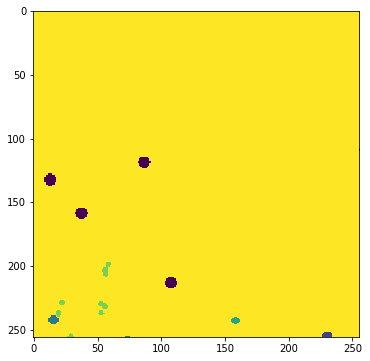

In [47]:
i = 8
plt.figure(figsize=(6, 6))
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, 0]))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [48]:
def rmse(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [49]:
y_true = K.constant(batch_counts)
y_pred = K.constant(counts_pred)
with sess.as_default():
    print(rmse(y_true, y_pred).eval())

[  5.15751839   5.15751839   4.62601328   5.03984165   5.15751839
   5.09901857   0.44721362   4.62601328   4.47213602  17.88295174
  17.88295174   5.38516474   0.99999994  17.01176071   1.09544516
  12.336936  ]


In [50]:
!rm -rf /home/lowik/data/models/segmentation_debug_counts/*

In [51]:
cb_checkpoint = ModelCheckpoint("/home/lowik/data/models/segmentation_debug_counts/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/lowik/data/models/segmentation_debug_counts/log_tb", batch_freq=10)

In [52]:
sgd = SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
adam = Adam()
unet.compile(optimizer=adam, loss=mean_squared_error)

In [53]:
h = unet.fit_generator(trainPatchesGenerator, 250, epochs=20,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=100,
                       class_weight=None,
                       max_q_size=1, workers=1, pickle_safe=False,
                       initial_epoch=0)

Epoch 1/20
250/250 [==============================] - 26s - loss: 150.9825 - val_loss: 116.5071
Epoch 2/20
250/250 [==============================] - 28s - loss: 175.8449 - val_loss: 90.6749
Epoch 3/20
250/250 [==============================] - 35s - loss: 152.8784 - val_loss: 90.7718
Epoch 4/20
249/250 [============================>.] - ETA: 0s - loss: 97.0972
Epoch 00003: reducing learning rate to 0.00010000000474974513.
250/250 [==============================] - 28s - loss: 97.0727 - val_loss: 99.0423
Epoch 5/20
250/250 [==============================] - 28s - loss: 213.6276 - val_loss: 67.3813
Epoch 6/20
250/250 [==============================] - 28s - loss: 94.2778 - val_loss: 98.7607
Epoch 7/20
250/250 [==============================] - 27s - loss: 137.6866 - val_loss: 60.5309
Epoch 8/20
250/250 [==============================] - 28s - loss: 177.6061 - val_loss: 64.4373
Epoch 9/20
249/250 [============================>.] - ETA: 0s - loss: 118.2185
Epoch 00008: reducing learning r

In [ ]:
for batch_x, counts in valPatchesGenerator:
    break

In [ ]:
counts_pred = unet.predict(batch_x)

In [ ]:
l = unet.get_layer("scale")

In [ ]:
l.weights

In [ ]:
with sess.as_default():
    print(l.weights[0].eval())

In [ ]:
i = 3
plt.figure(figsize=(6, 6))
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, 0]))
print("True counts: ", batch_counts[i, ...])
print("Pred counts: ", counts_pred[i, ...])

In [ ]:
unet.save("../data/unet_segmentation_ellipse_dmap_sgd_10epochs_200steps.h5")

In [ ]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [ ]:
batch_ypred = unet.predict(batch_x)

In [ ]:
batch_ypred.shape

In [ ]:
np.min(batch_ypred[:,:,2])

In [ ]:
gg = np.argmax(batch_ypred, axis=-1)

In [ ]:
np.unique(gg, return_counts=True)

In [ ]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(batch_ypred[i,...], axis=-1))

In [ ]:
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]) > 0.0007)

In [ ]:
i = 7
print("GT: ", np.sum(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0])))
print("Pred: ", np.sum(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0])))

In [ ]:
def full_image_process(im, net, patchGenerator, patch_size=(224, 224), batch_size=8, overlap=(64, 64)):
    h, w, c = im.shape
    n_patches_x = int(np.ceil((w - patch_size[1])/(patch_size[1] - overlap[1]) + 1))
    n_patches_y = int(np.ceil((h - patch_size[0])/(patch_size[0] - overlap[0]) + 1))
    print(n_patches_x, n_patches_x)
    
    dmap = np.zeros((h, w, 1), dtype=np.float32)
    dmap_count = np.zeros((h, w, 1), dtype=np.int8)
    batch_x = np.zeros((batch_size, ) + patch_size + (c, ), dtype=np.float32)
    batch_pos = np.zeros((batch_size, 4), dtype=np.int32)
    
    current_batch_size = 0
    for py in range(n_patches_y):
        y_start = py * (patch_size[0] - overlap[0])
        y_start = min(h - patch_size[0], y_start)
        y_end = y_start + patch_size[0]
        for px in range(n_patches_x):
            x_start = px * (patch_size[1] - overlap[1])
            x_start = min(w - patch_size[1], x_start)
            x_end = x_start + patch_size[1]
            
            # Keep filling the batch
            batch_x[current_batch_size, :, :, :] = im[y_start:y_end, x_start:x_end, :]
            batch_pos[current_batch_size, :] = np.array([y_start, y_end, x_start, x_end])
            current_batch_size += 1
            
            if current_batch_size == batch_size or (py == n_patches_y - 1 and px == n_patches_x - 1) :
                # time to predict
                batch_x_normed = patchGenerator.normalize_input(batch_x)
                batch_ylog = net.predict(batch_x_normed)
                batch_y = patchGenerator.denormalize_output(batch_ylog)
                # Fill the full dmap
                for i in range(current_batch_size):
                    y_start, y_end, x_start, x_end = tuple(batch_pos[i,:])
                    dmap[y_start:y_end, x_start:x_end, :] += batch_y[i,:,:,:]
                    dmap_count[y_start:y_end, x_start:x_end] += 1
                current_batch_size = 0
                
    return dmap, dmap_count

In [ ]:
im = cv2.imread("../data/sealion/Train/872.jpg")

In [ ]:
dmap, dmap_count = full_image_process(im, unet, valPatchesGenerator)

In [ ]:
plt.imshow(dmap[:,:,0])

In [ ]:
dmap_avg = dmap/dmap_count

In [ ]:
dmap_count.shape

In [ ]:
np.sum(dmap)

In [ ]:
np.sum(dmap_avg)

In [ ]:
dmap_gt = np.load("../data/sealion/TrainDensity/872_0.npz")